In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [20]:
# -----------------------------
# 1) Load & clean the CSV data
# -----------------------------
def load_monthly_prices(csv_path: str) -> pd.Series:
    df = pd.read_csv(csv_path)

    # Try to infer date and price columns (robust to different column names)
    cols_lower = {c.lower(): c for c in df.columns}
    date_candidates = ["date", "month_end", "monthend", "timestamp", "time"]
    price_candidates = ["price", "settle", "settlement", "value", "close", "px"]

    date_col = None
    for k in date_candidates:
        if k in cols_lower:
            date_col = cols_lower[k]
            break
    if date_col is None:
        # fallback: first column that parses well as datetime
        for c in df.columns:
            try:
                pd.to_datetime(df[c])
                date_col = c
                break
            except Exception:
                continue

    price_col = None
    for k in price_candidates:
        if k in cols_lower:
            price_col = cols_lower[k]
            break
    if price_col is None:
        # fallback: first numeric column
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if not numeric_cols:
            raise ValueError("Could not infer a numeric price column from the CSV.")
        price_col = numeric_cols[0]

    if date_col is None:
        raise ValueError("Could not infer a date column from the CSV.")

    df[date_col] = pd.to_datetime(df[date_col])
    df = df[[date_col, price_col]].dropna().sort_values(date_col)

    # Create a Series indexed by datetime
    s = pd.Series(df[price_col].astype(float).values, index=df[date_col].values)
    s = s[~s.index.duplicated(keep="last")]  # de-duplicate if needed

    # Basic sanity checks
    if (s <= 0).any():
        # For gas prices it should generally be > 0; if not, you can choose to filter or shift.
        # Here we raise, because log-model uses positive prices.
        bad = s[s <= 0]
        raise ValueError(f"Found non-positive prices, cannot model logs safely:\n{bad.head()}")

    return s


In [21]:
# ----------------------------------------------------
# 2) Fit model: log(price) = trend + month seasonality
# ----------------------------------------------------
class GasPriceEstimator:
    def __init__(self, month_end_prices: pd.Series):
        """
        month_end_prices: Series indexed by month-end datetimes, values are prices.
        """
        self.s = month_end_prices.sort_index()
        self.start = self.s.index.min()
        self.end = self.s.index.max()

        # Build design matrix for OLS on log prices
        df = pd.DataFrame({"date": self.s.index, "price": self.s.values})
        df["t_days"] = (df["date"] - self.start).dt.days.astype(float)
        df["month"] = df["date"].dt.month.astype(int)

        # Month dummies (1..12), drop one to avoid collinearity
        month_dummies = pd.get_dummies(df["month"], prefix="m", drop_first=True)
        X = pd.concat([pd.Series(1.0, index=df.index, name="const"),
                       df["t_days"].rename("t_days"),
                       month_dummies], axis=1).astype(float)

        y = np.log(df["price"].values)

        # OLS: beta = (X'X)^-1 X'y
        X_mat = X.values
        beta = np.linalg.lstsq(X_mat, y, rcond=None)[0]

        self.feature_names = list(X.columns)
        self.beta = beta

        # store fitted values for diagnostics
        y_hat = X_mat @ beta
        self.fitted_log = y_hat
        self.resid = y - y_hat

    def _predict_month_end_price(self, dt: pd.Timestamp) -> float:
        """
        Predict month-end price for a given datetime dt using fitted trend+seasonality.
        """
        dt = pd.Timestamp(dt)
        t_days = float((dt - self.start).days)
        month = int(dt.month)

        # Build row vector matching training features
        x = np.zeros(len(self.feature_names), dtype=float)
        for i, name in enumerate(self.feature_names):
            if name == "const":
                x[i] = 1.0
            elif name == "t_days":
                x[i] = t_days
            elif name.startswith("m_"):
                # dummy for month: m_2 means month==2, etc. (since drop_first=True, m_1 omitted)
                m_val = int(name.split("_")[1])
                x[i] = 1.0 if month == m_val else 0.0

        log_p = float(x @ self.beta)
        return float(np.exp(log_p))

    def _future_month_ends(self, months_ahead: int = 12) -> pd.Series:
        """
        Generate predicted month-end prices beyond last observed date.
        """
        last = pd.Timestamp(self.end)
        future_idx = []
        # Next month-end after last
        current = (last + pd.offsets.MonthEnd(1))
        for _ in range(months_ahead):
            future_idx.append(current)
            current = current + pd.offsets.MonthEnd(1)

        preds = [self._predict_month_end_price(d) for d in future_idx]
        return pd.Series(preds, index=pd.DatetimeIndex(future_idx))

    def estimate_price(self, date_input) -> float:
        """
        Estimate purchase price of gas at ANY date:
        - If within historical range: linear interpolation between adjacent month-end points.
        - If after last point: extrapolate up to 1 year using model-predicted month-ends,
          then interpolate between month-ends.
        """
        dt = pd.Timestamp(date_input)

        # Build an extended curve: historical month-ends + 12 months of predicted month-ends
        future = self._future_month_ends(months_ahead=12)
        curve = pd.concat([self.s, future]).sort_index()

        # If dt is before the first observed month-end, we can either extrapolate backwards or raise.
        # For typical storage needs, raising is safer than inventing history.
        if dt < curve.index.min():
            raise ValueError(f"Date {dt.date()} is before first available point {curve.index.min().date()}.")

        # If dt is beyond last supported date (last obs + 12 months), raise
        if dt > curve.index.max():
            raise ValueError(f"Date {dt.date()} is beyond extrapolation limit {curve.index.max().date()} (1 year ahead).")

        # Exact hit
        if dt in curve.index:
            return float(curve.loc[dt])

        # Find bracketing month-end dates for interpolation
        # left = last index <= dt, right = first index > dt
        idx = curve.index
        right_pos = idx.searchsorted(dt, side="right")
        left_pos = right_pos - 1
        left_dt = idx[left_pos]
        right_dt = idx[right_pos]

        left_p = float(curve.loc[left_dt])
        right_p = float(curve.loc[right_dt])

        # Linear interpolation in time (days). This is a pragmatic choice for daily estimation.
        total_days = (right_dt - left_dt).days
        w = (dt - left_dt).days / total_days
        return left_p + w * (right_p - left_p)

    # -------------------------
    # 3) Visualization helpers
    # -------------------------
    def plot_overview(self):
        plt.figure()
        plt.plot(self.s.index, self.s.values, marker="o")
        plt.title("Natural Gas Month-End Prices (Observed)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()

        future = self._future_month_ends(12)
        plt.figure()
        plt.plot(self.s.index, self.s.values, marker="o", label="Observed")
        plt.plot(future.index, future.values, marker="o", label="Model extrapolation (12m)")
        plt.title("Observed + 12-Month Extrapolation (Month-End)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_seasonality(self):
        df = pd.DataFrame({"price": self.s.values}, index=self.s.index)
        df["month"] = df.index.month
        month_stats = df.groupby("month")["price"].agg(["mean", "median", "std", "count"])

        plt.figure()
        plt.plot(month_stats.index, month_stats["mean"], marker="o")
        plt.title("Seasonality: Average Price by Month of Year")
        plt.xlabel("Month")
        plt.ylabel("Average price")
        plt.xticks(range(1, 13))
        plt.show()

        return month_stats

    def plot_residuals(self):
        plt.figure()
        plt.plot(self.s.index, self.resid, marker="o")
        plt.title("Model Residuals (log-space): trend + month seasonality")
        plt.xlabel("Date")
        plt.ylabel("Residual")
        plt.axhline(0.0)
        plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3931352669.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[c])
/tmp/ipython-input-3931352669.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


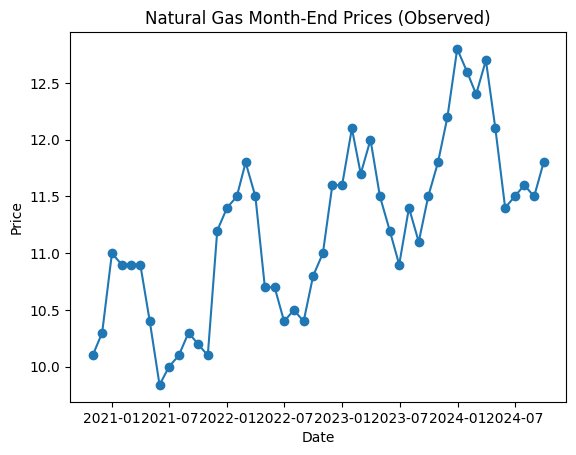

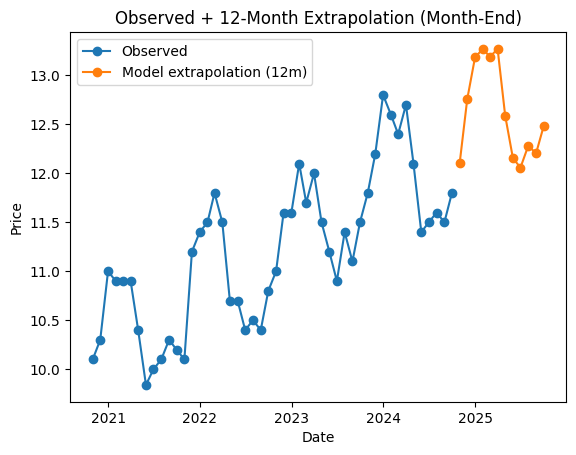

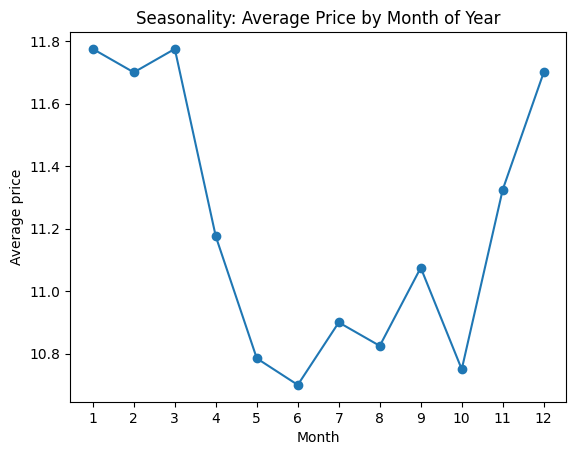

Seasonality summary by month:
         mean  median       std  count
month                                 
1      11.775   11.80  0.736546      4
2      11.700   11.75  0.616441      4
3      11.775   11.75  0.763217      4
4      11.175   11.10  0.771902      4
5      10.785   10.95  0.695390      4
6      10.700   10.65  0.648074      4
7      10.900   10.95  0.716473      4
8      10.825   10.75  0.573730      4
9      11.075   11.15  0.718215      4
10     10.750   10.55  0.818535      4
11     11.325   11.40  0.797392      4
12     11.700   11.50  0.774597      4


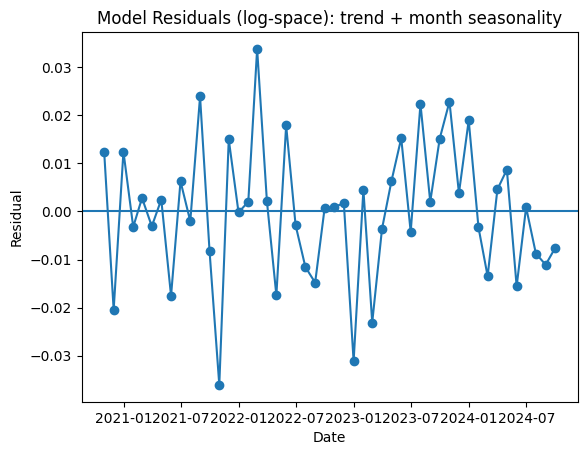

2022-01-15 -> 11.448387096774194
2024-09-30 -> 11.8
2025-03-10 -> 13.215647443397211


In [22]:
# -----------------------------
# Example usage (edit CSV path)
# -----------------------------
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')
    CSV_PATH = "/content/drive/MyDrive/data/Nat_Gas.csv"  # <-- change this to your filename
    s = load_monthly_prices(CSV_PATH)

    estimator = GasPriceEstimator(s)

    # Visualize patterns
    estimator.plot_overview()
    month_stats = estimator.plot_seasonality()
    print("Seasonality summary by month:")
    print(month_stats)

    estimator.plot_residuals()

    # Query the estimator
    for d in ["2022-01-15", "2024-09-30", "2025-03-10"]:
        print(d, "->", estimator.estimate_price(d))